In [10]:
import spacy
from nltk.corpus import stopwords

import umap
import hdbscan
from hdbscan.flat import (HDBSCAN_flat,
						  approximate_predict_flat,
						  membership_vector_flat,
						  all_points_membership_vectors_flat)
# PLOT CLUSTERS
import matplotlib.pyplot as plt
import pandas as pd

import text_process as tp

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
def get_data(path, y):

	texts = []
	labels = []

	with open(path, encoding='utf-8') as f:
		for line in f:
			line = line.strip()
			texts.append(line)
			labels.append(y)

	return texts, labels

def load_data():
	# load data
	paths = ['../data/train.negative.csv',
				'../data/train.non-negative.csv',
				'../data/test.negative.csv',
				'../data/test.non-negative.csv']

	# get data as list of dict with text and label
	train_neg_x_ls, train_neg_y_ls = get_data(paths[0], 1)
	train_non_x_ls, train_non_y_ls = get_data(paths[1], 0)
	test_neg_x_ls, test_neg_y_ls = get_data(paths[2], 1)
	test_non_x_ls, test_non_y_ls = get_data(paths[3], 0)

	train_data = train_neg_x_ls + train_non_x_ls
	# test_data = test_neg_x_ls + test_non_x_ls

	print('train data length: ', len(train_data))
	# 14643


	train_data = [tp.remove_punctuation(sentence) for sentence in train_data]
	train_data = [sentence.lower() for sentence in train_data]
	train_data = [sentence.strip().split() for sentence in train_data]

	train_data = [sentence for sentence in train_data if len(sentence) >= 5]

	train_data = [' '.join(sentence) for sentence in train_data]

	nlp = spacy.load('en_core_web_sm')
	train_data = [[token.lemma_ for token in nlp(sentence)] for sentence in train_data]

	stop_words = set(stopwords.words('english'))
	train_data = [ [word for word in sentence if not word in stop_words and word != ' '] for sentence in train_data]

	train_data = [' '.join(sentence) for sentence in train_data]

	print('train data length (after preprocessing): ', len(train_data))

	return train_data

In [12]:
def embed(train_data):
	# BRING MODEL & ENCODE DATA to EMBEDDING VALUE
	'''
	distilbert gives good balance between speed and performance
	supports multi-lingual models
	'''
	from sentence_transformers import SentenceTransformer
	model = SentenceTransformer('distilbert-base-nli-mean-tokens')
	embeddings = model.encode(train_data, show_progress_bar=True)

	print('embeddings: ', embeddings.shape)
	# (14643, 768)

	return embeddings

In [13]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [14]:
def plot(embeddings, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5):
	# REDUCE EMBEDDING DIMENSIONS using UMAP
	umap_embeddings = umap.UMAP(n_neighbors=n_neighbors,
								n_components=n_components,
								min_dist=min_dist,
								metric='cosine').fit_transform(embeddings)
	print('\ndone with reducing dimension')


	# ------------------------------------------------------------------------


	# CLUSTER EMBEDDINGS using HDBSCAN
	'''
	does not force data points meaning knows outliers
	'''
	cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
								metric='euclidean',
								cluster_selection_method='eom').fit(umap_embeddings)
	'''
	cluster = HDBSCAN_flat(umap_embeddings,
							cluster_selection_method='eom',
							n_clusters=20,
							min_cluster_size=min_cluster_size)
	'''	

	print('\ndone with clustering')


	# ------------------------------------------------------------------------


	# Prepare data
	umap_data = umap.UMAP(n_neighbors=n_neighbors,
							n_components=2,
							min_dist=min_dist,
							metric='cosine').fit_transform(embeddings)
	result = pd.DataFrame(umap_data, columns=['x', 'y'])
	result['labels'] = cluster.labels_


	# ------------------------------------------------------------------------


	# Visualize clusters
	fig, ax = plt.subplots(figsize=(20, 10))
	outliers = result.loc[result.labels == -1, :]
	clustered = result.loc[result.labels != -1, :]
	plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
	plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
	plt.colorbar()
	plt.show()

	print('\ndone with plot')


	# ------------------------------------------------------------------------


	#c-TF-IDF
	docs_df = pd.DataFrame(train_data, columns=["Doc"])
	docs_df['Topic'] = cluster.labels_
	docs_df['Doc_ID'] = range(len(docs_df))
	docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


	  
	tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(train_data))



	top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
	topic_sizes = extract_topic_sizes(docs_df);

	print(topic_sizes.head(10))
	print(len(topic_sizes))


	cnt = 0
	for i, row in topic_sizes.iterrows():
		topic_num = row['Topic']
		topic_size = row['Size']

		if topic_num == -1: continue

		print(topic_size, top_n_words[topic_num][:10])

		if cnt == 4: break
		cnt += 1
	
	return docs_per_topic, top_n_words, topic_sizes

In [15]:
'''
train_data = load_data()
embeddings = embed(train_data)


# MAIN
# def plot(embeddings, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5):
chng_neigh = [[2, 5, 0.0, 15],
			  [5, 5, 0.0, 15],
			  [10, 5, 0.0, 15],
			  [20, 5, 0.0, 15],
			  [50, 5, 0.0, 15],
			  [100, 5, 0.0, 15]]


for i in range(len(chng_neigh)):
	plot(embeddings, chng_neigh[i][0], chng_neigh[i][1], chng_neigh[i][2], chng_neigh[i][3])
'''

'\ntrain_data = load_data()\nembeddings = embed(train_data)\n\n\n# MAIN\n# def plot(embeddings, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5):\nchng_neigh = [[2, 5, 0.0, 15],\n\t\t\t  [5, 5, 0.0, 15],\n\t\t\t  [10, 5, 0.0, 15],\n\t\t\t  [20, 5, 0.0, 15],\n\t\t\t  [50, 5, 0.0, 15],\n\t\t\t  [100, 5, 0.0, 15]]\n\n\nfor i in range(len(chng_neigh)):\n\tplot(embeddings, chng_neigh[i][0], chng_neigh[i][1], chng_neigh[i][2], chng_neigh[i][3])\n'

In [16]:
train_data = load_data()
embeddings = embed(train_data)

train data length:  14643
train data length (after preprocessing):  13690


Batches: 100%|██████████| 428/428 [01:10<00:00,  6.07it/s]


embeddings:  (13690, 768)



done with reducing dimension

done with clustering


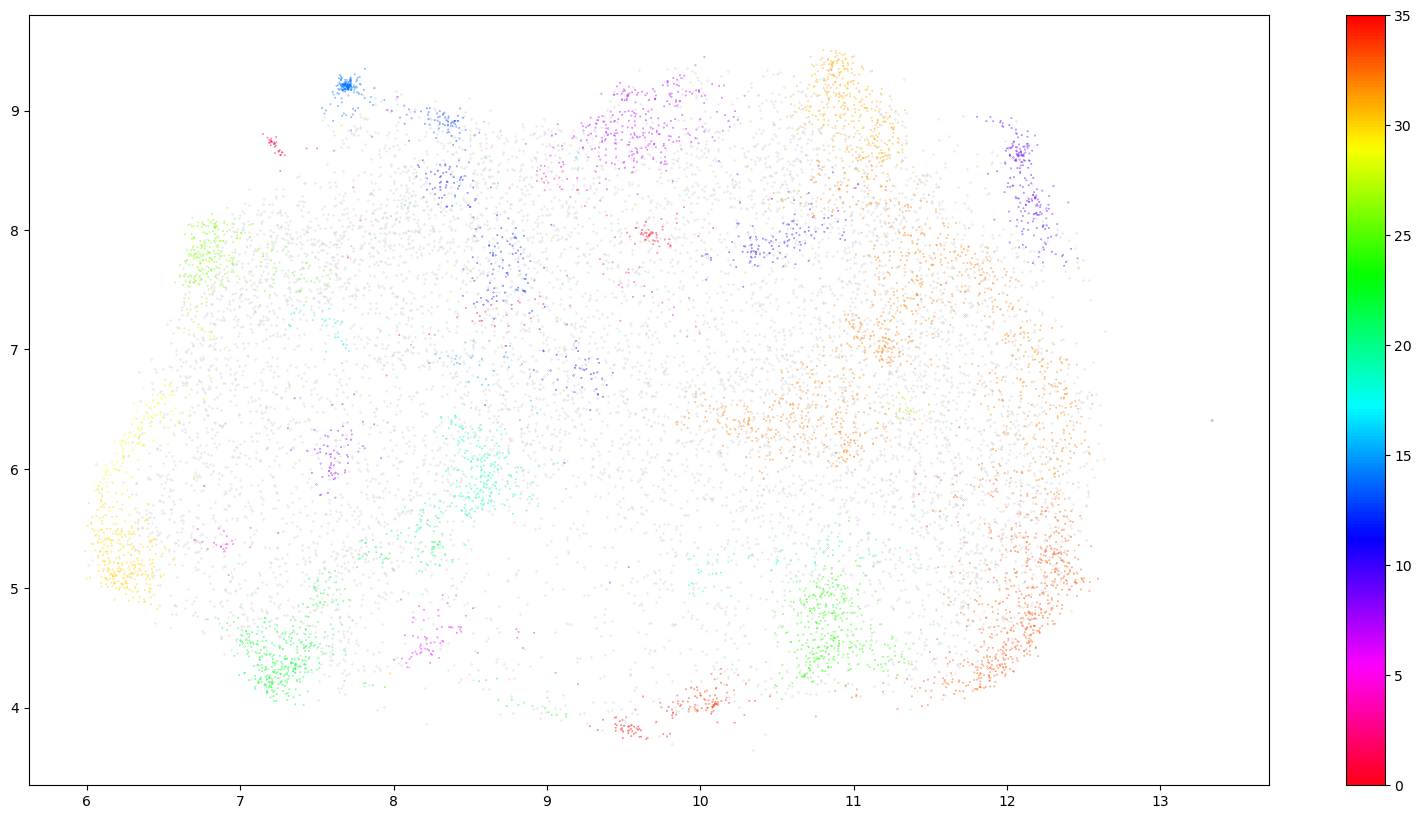


done with plot
    Topic  Size
0      -1  8129
33     32  1128
34     33   643
25     24   368
32     31   364
23     22   350
31     30   316
8       7   289
27     26   224
20     19   216
37
1128 [('cancel', 0.11016126479571922), ('flight', 0.1081001777794502), ('flightle', 0.07322178018486211), ('hour', 0.06770606120452569), ('delay', 0.06358093666926158), ('plane', 0.03980811508336228), ('late', 0.035360873166463566), ('usairway', 0.02974416680910762), ('wait', 0.027411712190015015), ('usairways', 0.027117719192934896)]
643 [('bad', 0.0996498555332765), ('customer', 0.08400762046880698), ('service', 0.07894883064796226), ('rude', 0.05429478382948005), ('airline', 0.04783955632357755), ('experience', 0.046454225363394), ('terrible', 0.04053065612239538), ('usairways', 0.03617894237238035), ('horrible', 0.03210556545242624), ('usairway', 0.028207167972172303)]
368 [('fly', 0.06939331205606511), ('airline', 0.045839459122686416), ('customer', 0.04411001217125725), ('service', 0.0431

In [17]:
docs_per_topic, top_n_words, topic_sizes = plot(embeddings, 100, 5, 0.0, 15)